In [1]:
import bibdb
import pickle, bz2

data = pickle.load(bz2.open('publications.pk.bz2', 'rb'))
publications = data['publications']
profs = data['profs']
authors = data['authors']
author_pubs = data['author_pubs']
del data

## Tokenization et lematization

La fonction `text_cleaning` implémente une tokenization et lematization du corpus a l'aide de la bibliothèque `nltk`. Une liste de stop-words anglais est utilisée, les nombres sont transformé en `[number]` et la ponctuation est retirée.

La lematization est réalisée avec wordnet et un POS tagger (Perceptron Tagger de nltk). Les deux premières lettres du tag sont rajoutées au lemme : "word/NN".

In [ ]:
from text_cleaning import text_cleaning

lem_abstracts = []
lem_titles = []
for i, pub in enumerate(publications):
    if i & 1023 == 0:
        print('%.2f%%' % (100*i/len(publications)))
    
    lem_abstracts.append(text_cleaning(pub.en_abstract))
    
    en_titles = [ref.ref for ref in pub.refs if ref.reftype=='en_title']
    if en_titles:
        title = max(en_titles, key=len) # Longest english title
        lem_titles.append(text_cleaning(title))
    else:
        lem_titles.append([]) # keeps lists aligned

0.00%
1.70%
3.40%
5.10%
6.80%
8.50%
10.20%
11.90%
13.60%


Cette opération prend du temps (20min) et donc les résultats sont sauvegardées :

In [ ]:
pickle.dump(dict(lem_abstracts=lem_abstracts,
                 lem_titles=lem_titles),
            bz2.open('lems.pk.bz2', 'wb'))

In [4]:
import pickle, bz2
data = pickle.load(bz2.open('lems.pk.bz2', 'rb'))
lem_abstracts = data['lem_abstracts']
lem_titles = data['lem_titles']
del data

In [5]:
lem_abstract_withtitles = [lem_title + lem_abstract 
                           for lem_title, lem_abstract in zip(lem_titles, lem_abstracts)]

## Fréquence des mots, filtrage

Les lemmes taggés sont ensuite indexés avec `gensim.corpora.Dictionary`. Cet objet calcule également la fréquence document des mots.

In [6]:
from itertools import chain
import gensim

dictionary = gensim.corpora.Dictionary(lem_abstract_withtitles)

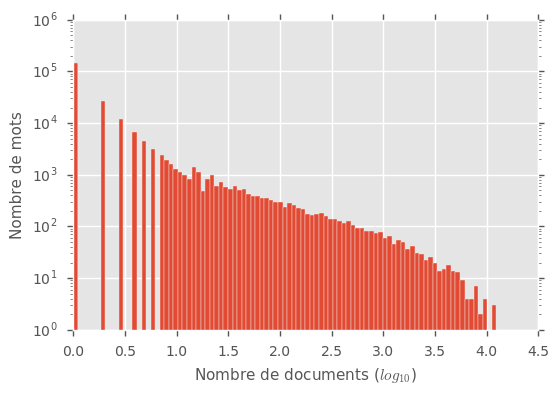

In [7]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.hist([np.log10(count) for count in dictionary.dfs.values()],
         100, log=True)
plt.xlabel('Nombre de documents ($log_{10}$)')
plt.ylabel('Nombre de mots');

Les mot utilisés moins dans moins de 5 documents, ou dans plus de 1/4 des document sont retirés :

In [8]:
dictionary.filter_extremes(no_below=5, no_above=0.25, keep_n=None)

## Modèle `bag of words` par publication
Un modèle `bag of words` est construit en utilisant les indices numériques de `dictionary` (cela filtre aussi les mots).

In [9]:
bows = [dictionary.doc2bow(lems) for lems in lem_abstract_withtitles]

In [11]:
tfidfmodel = gensim.models.tfidfmodel.TfidfModel(bows, dictionary=dictionary)
tfidfs = tfidfmodel[bows]
lsimodel = gensim.models.lsimodel.LsiModel(tfidfs, id2word=dictionary)
lsimodel.save(bz2.open('lsimodel_bypub.pk.bz2', 'wb'))

In [16]:
lsimodel.save('lsimodel_bypub')

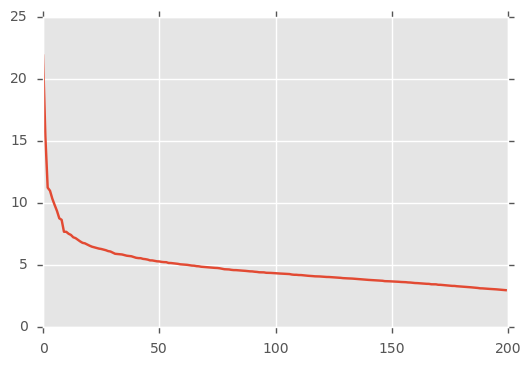

In [12]:

plt.plot(lsimodel.projection.s);

In [13]:
hdpmodel = gensim.models.hdpmodel.HdpModel(bows, dictionary)
hdpmodel.save('hdpmodel_bypub.pk')

In [23]:
tc = lsimodel[bows]

In [28]:
type(authors)

set

In [27]:
gensim.matutils.corpus2dense(lsimodel[bows], lsimodel.num_topics).shape

(200, 36687)

In [29]:
gensim.matutils.corpus2csc(hdpmodel[bows]).shape

(150, 36687)